<a href="https://colab.research.google.com/github/Hitsaa/ship-performance-anomaly-detection/blob/main/ship_performance_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks'

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install umap-learn

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from scipy.spatial.distance import pdist,squareform
import umap
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
import random

In [ ]:
input_file_path = '/content/drive/MyDrive/Colab Notebooks/ML Learning Datasets/Ship_Performance_Dataset.csv'

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks


In [ ]:
def mean_anomaly_score(scores):
    return np.mean(scores)

def anomaly_score_variance(scores):
    return np.var(scores)

def anomaly_score_entropy(scores):
    hist, _ = np.histogram(scores, bins=50, density=True)
    return entropy(hist)

def precision_pseudo(anomaly_scores, synthetic_scores):
    threshold = np.percentile(anomaly_scores, 90)
    return np.mean(anomaly_scores > threshold)

def baseline_comparison(anomaly_scores):
    random_scores = np.random.normal(0, 1, len(anomaly_scores))
    return np.mean(anomaly_scores > random_scores)

def permutation_test(X, anomaly_scores):
    n_permutations = 100
    original_mean = np.mean(anomaly_scores)
    permuted_means = []

    for _ in range(n_permutations):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted)
        iso_forest = IsolationForest(contamination=0.1, random_state=42)
        scores = -iso_forest.fit_predict(X_permuted)
        permuted_means.append(np.mean(scores))

    return np.mean(original_mean > permuted_means)


def calculate_qnx(X_original, X_reduced, k_values):
    n = len(X_original)
    qnx_values = []

    dist_original = squareform(pdist(X_original))
    dist_reduced = squareform(pdist(X_reduced))

    for k in k_values:
        neighbors_original = np.argsort(dist_original, axis=1)[:, 1:k+1]

        preserved = 0
        for i in range(n):
            neighbors_reduced = np.argsort(dist_reduced[i])[1:k+1]
            preserved += len(set(neighbors_original[i]) & set(neighbors_reduced))

        qnx = preserved / (n * k)
        qnx_values.append(qnx)

    return np.array(qnx_values)


def calculate_lcmc(qnx_values, k_values, n):
    lcmc = np.max(qnx_values - k_values / n)
    k_star = k_values[np.argmax(qnx_values - k_values / n)]
    auc_logk = np.trapz(qnx_values, np.log(k_values)) / (np.log(k_values[-1]) - np.log(k_values[0]))
    return lcmc, k_star, auc_logk



In [ ]:
df = pd.read_csv(input_file_path)

In [ ]:
df.head()

,Date,Ship_Type,Route_Type,Engine_Type,Maintenance_Status,Speed_Over_Ground_knots,Engine_Power_kW,Distance_Traveled_nm,Draft_meters,Weather_Condition,Cargo_Weight_tons,Operational_Cost_USD,Revenue_per_Voyage_USD,Turnaround_Time_hours,Efficiency_nm_per_kWh,Seasonal_Impact_Score,Weekly_Voyage_Count,Average_Load_Percentage
0,2023-06-04,Container Ship,NaN,Heavy Fuel Oil (HFO),Critical,12.597558,2062.983982,1030.943616,14.132284,Moderate,1959.017882,483832.354540,292183.273104,25.867077,1.455179,1.415653,1,93.769249
1,2023-06-11,Fish Carrier,Short-haul,Steam Turbine,Good,10.387580,1796.057415,1060.486382,14.653083,Rough,162.394712,483388.000509,883765.787360,63.248196,0.290361,0.885648,6,93.895372
2,2023-06-18,Container Ship,Long-haul,Diesel,Fair,20.749747,1648.556685,658.874144,7.199261,Moderate,178.040917,448543.404044,394018.746904,49.418150,0.499595,1.405813,9,96.218244
3,2023-06-25,Bulk Carrier,Transoceanic,Steam Turbine,Fair,21.055102,915.261795,1126.822519,11.789063,Moderate,1737.385346,261349.605449,87551.375175,22.409110,0.702906,1.370704,1,66.193698
4,2023-07-02,Fish Carrier,Transoceanic,Diesel,Fair,13.742777,1089.721803,1445.281159,9.727833,Moderate,260.595103,287718.375160,676121.459632,64.158231,1.331343,0.583383,8,80.008581


In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns

In [ ]:
df.dtypes

,0
Date,object
Ship_Type,object
Route_Type,object
Engine_Type,object
Maintenance_Status,object
Speed_Over_Ground_knots,float64
Engine_Power_kW,float64
Distance_Traveled_nm,float64
Draft_meters,float64
Weather_Condition,object


In [ ]:
numeric_columns

Index(['Speed_Over_Ground_knots', 'Engine_Power_kW', 'Distance_Traveled_nm',
       'Draft_meters', 'Cargo_Weight_tons', 'Operational_Cost_USD',
       'Revenue_per_Voyage_USD', 'Turnaround_Time_hours',
       'Efficiency_nm_per_kWh', 'Seasonal_Impact_Score', 'Weekly_Voyage_Count',
       'Average_Load_Percentage'],
      dtype='object')

In [ ]:
df_numeric = df[numeric_columns]

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

In [ ]:
df_scaled

array([[-1.16100314,  0.42598003, -0.0096083 , ...,  1.42900788,
        -1.50734649,  1.2786495 ],
       [-1.67361736,  0.0536309 ,  0.0423553 , ..., -0.41002457,
         0.41782389,  1.28734312],
       [ 0.72993369, -0.1521252 , -0.66405165, ...,  1.39486426,
         1.57292613,  1.44745821],
       ...,
       [-0.18304695, -0.57751326,  0.59813119, ..., -0.96604362,
         0.41782389,  0.39676311],
       [ 1.28265711,  0.37737941, -0.73377169, ..., -0.34995325,
        -1.12231241,  1.21553546],
       [-1.40909487,  1.63345423,  1.57218173, ...,  0.99024888,
        -1.12231241, -0.62234008]])

In [ ]:
df_scaled = pd.DataFrame(df_scaled, columns=df_numeric.columns)

In [ ]:
df_scaled

,Speed_Over_Ground_knots,Engine_Power_kW,Distance_Traveled_nm,Draft_meters,Cargo_Weight_tons,Operational_Cost_USD,Revenue_per_Voyage_USD,Turnaround_Time_hours,Efficiency_nm_per_kWh,Seasonal_Impact_Score,Weekly_Voyage_Count,Average_Load_Percentage
0,-1.161003,0.425980,-0.009608,1.461520,1.658525,1.623465,-0.845173,-0.900768,1.627007,1.429008,-1.507346,1.278649
1,-1.673617,0.053631,0.042355,1.642611,-1.557798,1.620311,1.336484,1.219556,-1.259663,-0.410025,0.417824,1.287343
2,0.729934,-0.152125,-0.664052,-0.949214,-1.529788,1.372949,-0.469621,0.435091,-0.741138,1.394864,1.572926,1.447458
3,0.800762,-1.175035,0.159036,0.646741,1.261758,0.044058,-1.599821,-1.096910,-0.237289,1.273042,-1.507346,-0.622127
4,-0.895364,-0.931672,0.719182,-0.069985,-1.381999,0.231250,0.570727,1.271175,1.320115,-1.458833,1.187892,0.330130
...,...,...,...,...,...,...,...,...,...,...,...,...
2731,-1.390536,1.619237,-1.400838,1.311522,-1.279032,-0.121878,0.775264,0.306570,0.499631,0.975300,-0.737278,-0.027993
2732,-0.869845,0.563101,-0.360669,1.628595,-1.457700,-1.661980,-0.542099,1.280686,-0.359792,-0.391160,-1.122312,0.646281
2733,-0.183047,-0.577513,0.598131,-0.216484,1.070673,-1.251272,-1.059299,0.669519,-0.506763,-0.966044,0.417824,0.396763
2734,1.282657,0.377379,-0.733772,-1.149293,-1.573825,-1.632075,1.026514,-1.554859,0.240422,-0.349953,-1.122312,1.215535


In [ ]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
anomalies = iso_forest.fit_predict(df_scaled)

In [ ]:
anomalies

array([-1, -1,  1, ...,  1,  1, -1])

In [ ]:
anomaly_scores = -iso_forest.score_samples(df_scaled)

In [ ]:
anomaly_scores

array([0.5495633 , 0.58072798, 0.52587022, ..., 0.47648242, 0.52773595,
       0.54891747])

In [ ]:
results_df = pd.DataFrame({
    'metrics': [
        'Mean Score',
        'Variance',
        'Entropy',
        'Precision_pseudo',
        'Baseline comparison',
        'Permutation test'
    ],
    'values': [
        np.mean(anomaly_scores),
        np.var(anomaly_scores),
        entropy(np.histogram(anomaly_scores, bins=50, density=True)[0]),
        np.mean(anomaly_scores > np.percentile(anomaly_scores, 90)),
        np.mean(anomaly_scores > np.random.normal(0, 1, len(anomaly_scores))),
        np.mean([np.mean(-IsolationForest(contamination=0.1, random_state=42).fit_predict(
            np.random.permutation(df_scaled))) for _ in range(100)])
    ]
})

In [ ]:
results_df

,metrics,values
0,Mean Score,0.514486
1,Variance,0.000578
2,Entropy,3.418640
3,Precision_pseudo,0.100146
4,Baseline comparison,0.684576
5,Permutation test,-0.799708


In [ ]:
results_df['values'] = results_df['values'].apply(lambda x: f"{x:.4f}")

results_df['description'] = [
    'Mean value of anomaly scores',
    'Variance of anomaly scores',
    'Entropy of anomaly score distribution',
    'Pseudo-accuracy of anomaly detection',
    'Comparison with baseline random distribution',
    'Result of permutation test'
]


In [ ]:
results_df

,metrics,values,description
0,Mean Score,0.5145,Mean value of anomaly scores
1,Variance,0.0006,Variance of anomaly scores
2,Entropy,3.4186,Entropy of anomaly score distribution
3,Precision_pseudo,0.1001,Pseudo-accuracy of anomaly detection
4,Baseline comparison,0.6846,Comparison with baseline random distribution
5,Permutation test,-0.7997,Result of permutation test


In [ ]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
"""
You are asking PCA to reduce your high-dimensional dataset (12 features in your case) down to 2 principal components.
PCA finds directions (linear combinations of your original features) that capture the maximum variance in the data.

fit → PCA calculates eigenvectors and eigenvalues of the covariance matrix of your scaled data.
  Eigenvectors = the "directions" of maximum variance (principal components).
  Eigenvalues = how much variance each component explains.

transform → Projects (df_scaled) into the new coordinate system formed by the top 2 principal components.
The result is an array with shape (rows, 2).
So if you had, say, N rows originally, you’ll now get N rows but only 2 columns (PC1, PC2).

df_pca = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])
Finally, you convert the PCA result (a NumPy array) into a DataFrame with column names PC1 and PC2.
PC1 = the first principal component (direction of max variance).
PC2 = the second principal component (orthogonal to PC1, capturing next most variance).

This gives you a new 2D representation of your dataset, useful for visualization, clustering, or as input to other ML models.
"""

reducer = umap.UMAP(n_components=2, random_state=42)
df_umap = reducer.fit_transform(df_scaled)
df_umap = pd.DataFrame(df_umap, columns=['UMAP1', 'UMAP2'])
"""
1. reducer = umap.UMAP(n_components=2, random_state=42)

You’re creating a UMAP model (umap-learn library).
n_components=2 → You want to reduce your dataset down to 2 dimensions (just like PCA).
random_state=42 → Ensures reproducibility (so you get the same embedding each run).

Unlike PCA (a linear method), UMAP (Uniform Manifold Approximation and Projection) is a non-linear dimensionality reduction technique.
It preserves both local structure (points that are close in high-dimensional space stay close in 2D) and global structure better than methods like t-SNE.

2. df_umap = reducer.fit_transform(df_scaled)

fit → UMAP builds a graph of the high-dimensional data, figuring out which points are neighbors.
transform → It then projects the points into a 2D space (n_components=2) while trying to keep neighbor relationships intact.
Result: You get an array of shape (rows, 2) → two coordinates per sample (UMAP1, UMAP2).

3. df_umap = pd.DataFrame(df_umap, columns=['UMAP1', 'UMAP2'])
Converts the NumPy output into a DataFrame with two columns:

UMAP1 → first embedding axis.
UMAP2 → second embedding axis.
Now each row of your dataset has a 2D embedding — useful for:

Visualization (scatter plots of clusters).
Preprocessing step for clustering (e.g., k-means on UMAP output).
Feature reduction for ML models.

"""
iso_forest_pca = IsolationForest(contamination=0.1, random_state=42)
anomalies_pca = iso_forest_pca.fit_predict(df_pca)
anomaly_scores_pca = -iso_forest_pca.score_samples(df_pca)

iso_forest_umap = IsolationForest(contamination=0.1, random_state=42)
anomalies_umap = iso_forest_umap.fit_predict(df_umap)
anomaly_scores_umap = -iso_forest_umap.score_samples(df_umap)

"""
Creates an Isolation Forest model (tree-based anomaly detection).
contamination=0.1 → assumes ~10% of the data are anomalies.
random_state=42 → makes results reproducible.

fit → trains the Isolation Forest on the PCA-reduced data (df_pca, i.e., 2D features).
predict → assigns each point:
1 = normal (inlier)
-1 = anomaly (outlier)
So anomalies_pca is an array of labels.

score_samples gives the anomaly score for each sample.
Higher score = more abnormal.
By default, more negative values mean more anomalous, so you negate (-) to make "larger = more anomalous".

anomalies_umap = iso_forest_umap.fit_predict(df_umap)

Fits the Isolation Forest on the 2D UMAP features.
Produces anomaly labels (1 normal, -1 anomaly).

"""

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


'\nCreates an Isolation Forest model (tree-based anomaly detection).\ncontamination=0.1 → assumes ~10% of the data are anomalies.\nrandom_state=42 → makes results reproducible.\n\nfit → trains the Isolation Forest on the PCA-reduced data (df_pca, i.e., 2D features).\npredict → assigns each point:\n1 = normal (inlier)\n-1 = anomaly (outlier)\nSo anomalies_pca is an array of labels.\n\nscore_samples gives the anomaly score for each sample.\nHigher score = more abnormal.\nBy default, more negative values mean more anomalous, so you negate (-) to make "larger = more anomalous".\n\nanomalies_umap = iso_forest_umap.fit_predict(df_umap)\n\nFits the Isolation Forest on the 2D UMAP features.\nProduces anomaly labels (1 normal, -1 anomaly).\n\n'

In [ ]:
dim_reduction_results = pd.DataFrame({
    'metrics': [
        'Mean Score (PCA)',
        'Variance (PCA)',
        'Entropy (PCA)',
        'Mean Score (UMAP)',
        'Variance (UMAP)',
        'Entropy (UMAP)'
    ],
    'values': [
        np.mean(anomaly_scores_pca),
        np.var(anomaly_scores_pca),
        entropy(np.histogram(anomaly_scores_pca, bins=50, density=True)[0]),
        np.mean(anomaly_scores_umap),
        np.var(anomaly_scores_umap),
        entropy(np.histogram(anomaly_scores_umap, bins=50, density=True)[0])
    ]
})

In [ ]:
dim_reduction_results['values'] = dim_reduction_results['values'].apply(lambda x: f"{x:.4f}")

dim_reduction_results['description'] = [
    'Mean value of anomaly scores for PCA',
    'Variance of anomaly scores for PCA',
    'Entropy of anomaly score distribution for PCA',
    'Mean value of anomaly scores for UMAP',
    'Variance of anomaly scores for UMAP',
    'Entropy of anomaly score distribution for UMAP'
]


In [ ]:
final_results = pd.concat([results_df, dim_reduction_results], ignore_index=True)

final_results.to_csv('analysis_results.csv', index=False, encoding='utf-8')

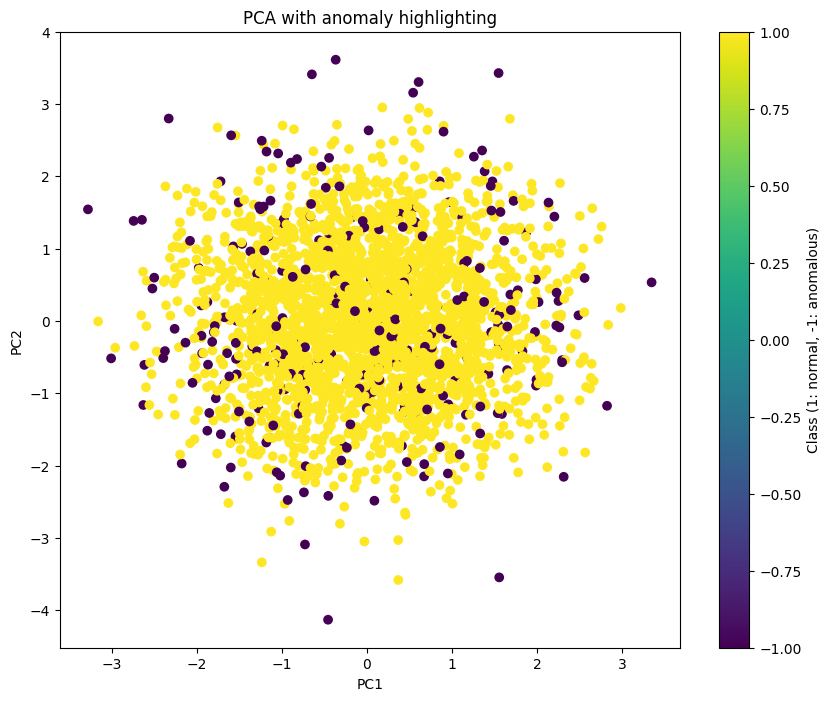

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=anomalies, cmap='viridis')
plt.title('PCA with anomaly highlighting')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Class (1: normal, -1: anomalous)')
plt.show()

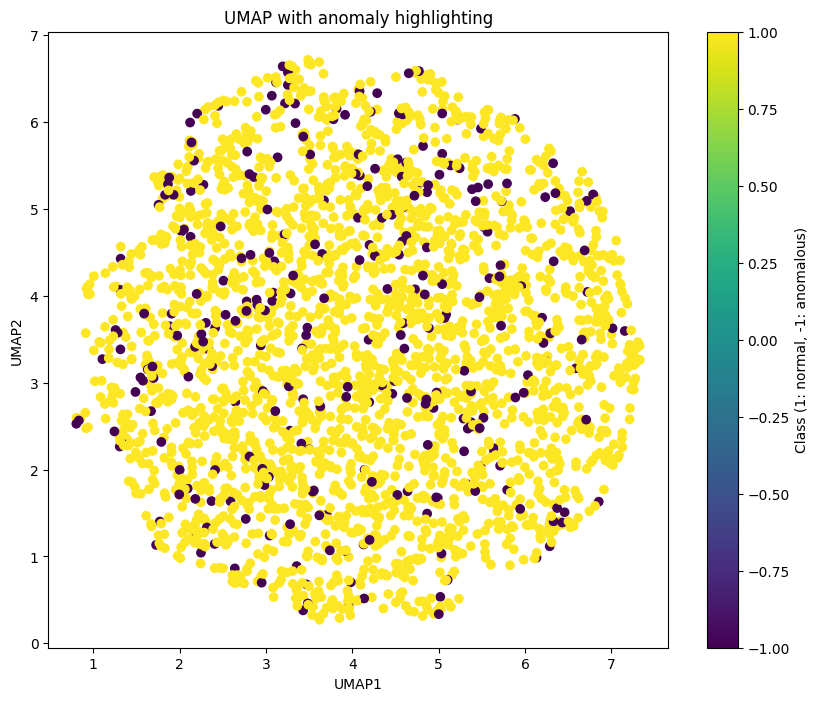

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(df_umap['UMAP1'], df_umap['UMAP2'], c=anomalies, cmap='viridis')
plt.title('UMAP with anomaly highlighting')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Class (1: normal, -1: anomalous)')
plt.show()

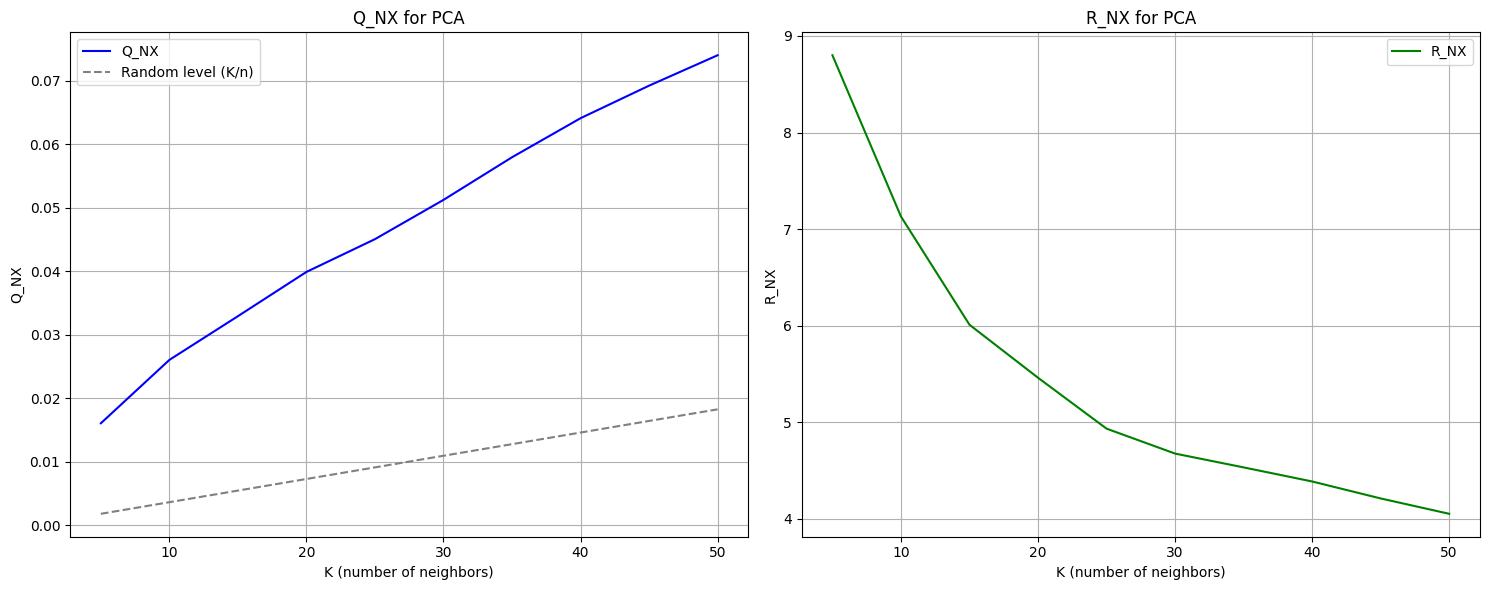

In [ ]:
k_values = np.arange(5, 51, 5)
qnx_values_pca = calculate_qnx(df_scaled, df_pca, k_values)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Q_NX plot
ax[0].plot(k_values, qnx_values_pca, label='Q_NX', color='blue')
ax[0].plot(k_values, k_values / len(df_scaled), '--', color='gray', label='Random level (K/n)')
ax[0].set_title('Q_NX for PCA')
ax[0].set_xlabel('K (number of neighbors)')
ax[0].set_ylabel('Q_NX')
ax[0].legend()
ax[0].grid()

# R_NX plot
ax[1].plot(k_values, qnx_values_pca / (k_values / len(df_scaled)), color='green', label='R_NX')
ax[1].set_title('R_NX for PCA')
ax[1].set_xlabel('K (number of neighbors)')
ax[1].set_ylabel('R_NX')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()


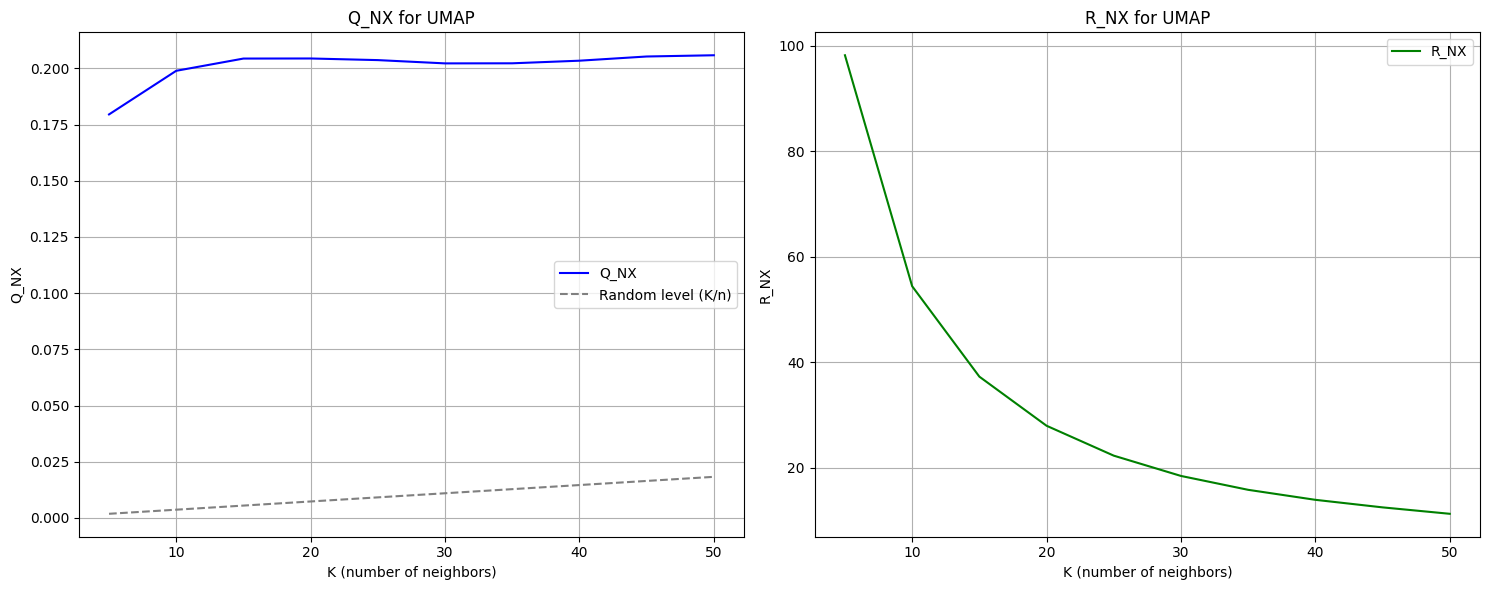

In [ ]:
qnx_values_umap = calculate_qnx(df_scaled, df_umap, k_values)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Q_NX plot
ax[0].plot(k_values, qnx_values_umap, label='Q_NX', color='blue')
ax[0].plot(k_values, k_values / len(df_scaled), '--', color='gray', label='Random level (K/n)')
ax[0].set_title('Q_NX for UMAP')
ax[0].set_xlabel('K (number of neighbors)')
ax[0].set_ylabel('Q_NX')
ax[0].legend()
ax[0].grid()

# R_NX plot
ax[1].plot(k_values, qnx_values_umap / (k_values / len(df_scaled)), color='green', label='R_NX')
ax[1].set_title('R_NX for UMAP')
ax[1].set_xlabel('K (number of neighbors)')
ax[1].set_ylabel('R_NX')
ax[1].legend()
ax[1].grid()

plt.tight_layout()
plt.show()

In [ ]:
print("\nResults:")
print(final_results.to_string(index=False))


Results:
            metrics  values                                    description
         Mean Score  0.5145                   Mean value of anomaly scores
           Variance  0.0006                     Variance of anomaly scores
            Entropy  3.4186          Entropy of anomaly score distribution
   Precision_pseudo  0.1001           Pseudo-accuracy of anomaly detection
Baseline comparison  0.6846   Comparison with baseline random distribution
   Permutation test -0.7997                     Result of permutation test
   Mean Score (PCA)  0.4655           Mean value of anomaly scores for PCA
     Variance (PCA)  0.0034             Variance of anomaly scores for PCA
      Entropy (PCA)  3.3437  Entropy of anomaly score distribution for PCA
  Mean Score (UMAP)  0.4950          Mean value of anomaly scores for UMAP
    Variance (UMAP)  0.0017            Variance of anomaly scores for UMAP
     Entropy (UMAP)  3.6301 Entropy of anomaly score distribution for UMAP
